## Pymultifracs:<br> python multifractal analysis toolbox

[github.com/neurospin/pymultifracs](github.com/neurospin/pymultifracs)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context='paper')
figure_folder = 'figures/fBm/'

import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 175
from scipy.io import loadmat

### Let's simulate a couple signals

In [3]:
from pymultifracs.simul import mrw, fbm

X_fbm = np.diff(fbm(shape=65536, H=0.8))
X_mrw = np.diff(mrw(shape=65536, H=0.8, lam=np.sqrt(0.05), L=65536))

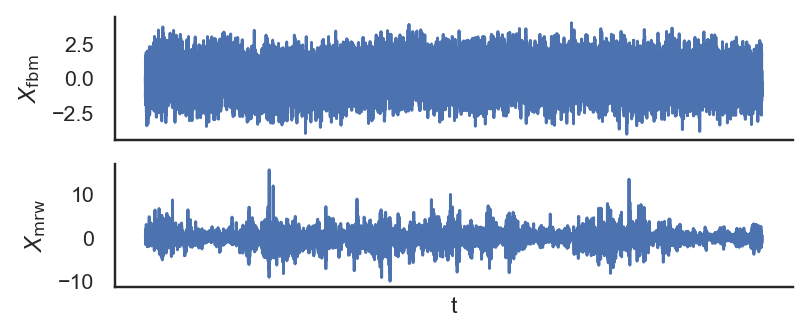

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 2))
ax[0].plot(X_fbm / np.std(X_fbm))
ax[0].set(ylabel='$X_{\mathrm{fbm}}$')
ax[1].plot(X_mrw / np.std(X_mrw))
ax[1].set(ylabel='$X_{\mathrm{mrw}}$', xlabel='t', xticks=[])
sns.despine()

## Wavelet analysis

`j1`, `j2_reg` are the scale bounds on which p-leader correcetion is computed

`p_exp` selects the $p$-exponent (`np.inf` for wavelet leaders)

`gamint` is the fractional integration coefficient

In [5]:
from pymultifracs.wavelet import wavelet_analysis

j1, j2 = 2, 10

WT_fbm = wavelet_analysis(X_fbm, p_exp=2, j1=j1, j2_reg=j2, gamint=1)
WT_mrw = wavelet_analysis(X_mrw, p_exp=2, j1=j1, j2_reg=j2, gamint=1)

WT_fbm.eta_p, WT_mrw.eta_p

(array([1.60682833]), array([1.5517144]))

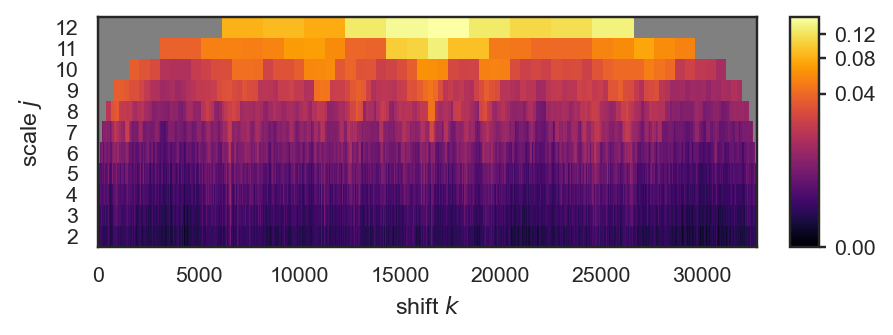

In [6]:
from pymultifracs.viz import plot_coef

plot_coef(WT_mrw.wt_leaders.values, j1=2, j2=12, figsize=(5, 1.8))

## Multifractal analysis

In [7]:
from pymultifracs.mfa import mf_analysis
from pymultifracs.utils import build_q_log

lwt_fbm, lwt_mrw = mf_analysis(
    [WT_fbm.wt_leaders, WT_mrw.wt_leaders], [(j1, j2)], n_cumul=2,
    q=build_q_log(.1, 10, 50))

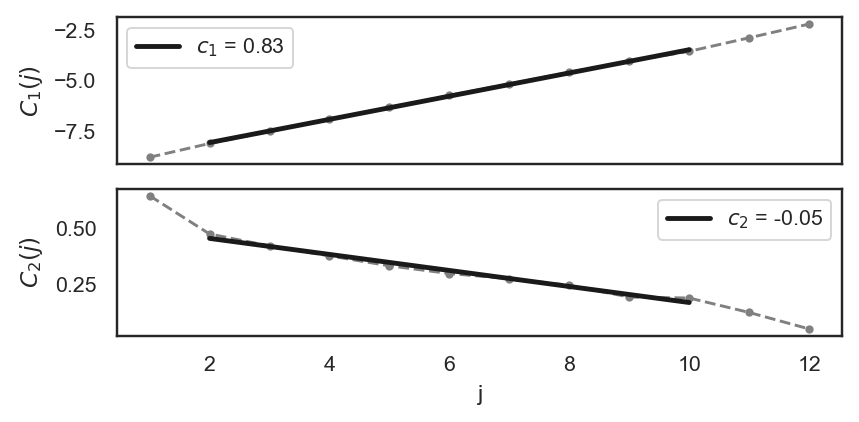

In [8]:
lwt_mrw.cumulants.plot(figsize=(5, 2.5))

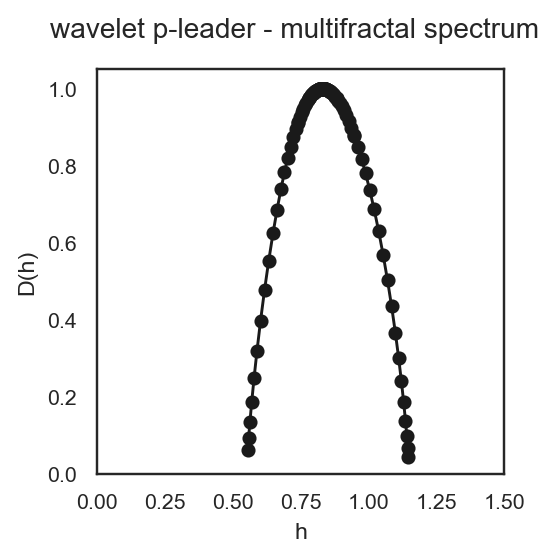

In [9]:
plt.figure(figsize=(3, 3))
lwt_mrw.spectrum.plot()

## Practical example on MEG

Load a recording: Open neuro MIND data ([`ds004107`](https://openneuro.org/datasets/ds004107/versions/1.0.0))

subject `sub-mind002`, session `ses-02`, resting state recording

Already processed: maxwell filtering + notch filter + ICA denoising

Available at [filesender](https://filesender.renater.fr/?s=download&token=db64defc-6e5e-48a4-8eb8-c1a75e912ece)

In [10]:
raw = loadmat('raw_ica.mat')

data = raw['data'].transpose()[50000:-50000]
sfreq = raw['sfreq'].squeeze()

Let's figure out which scale to start the analysis from

In [11]:
from pymultifracs.utils import freq2scale

freq2scale(1, sfreq)

10.393030434041073

And now which scale to end the analysis: the data is highpass filtered @ 0.1 Hz

In [12]:
freq2scale(.1, sfreq)

13.714958528928435

In [13]:
j1, j2 = 10, 14

We need to figure out the value of $\eta_p$, in order to determine if (fractional) integration is necessary

In [ ]:
WT = wavelet_analysis(data[:, :306], p_exp=2, j1=j1, j2_reg=j2,
                      gamint=0)

\\ad.helsinki.fi\dept\nttk_palva\projects\merlin\pymultifracs\pymultifracs\wavelet.py:52: UserWarning: eta(p) = -0.5522083929375636 <= 0, p-Leaders correction was not                        applied. A smaller value of p (or larger value of                        gamint) should be selected.
  warnings.warn(f"eta(p) = {eta_p.min()} <= 0, p-Leaders correction was not\


Here integration is needed, let's integrate with $\gamma^{\mathrm{int}}=1$

In [15]:
WT = wavelet_analysis(data[:, :306], p_exp=2, j1=j1, j2_reg=j2,
                      gamint=1)

In [16]:
lwt = mf_analysis(WT.wt_leaders, [(j1, j2)], estimates='c')

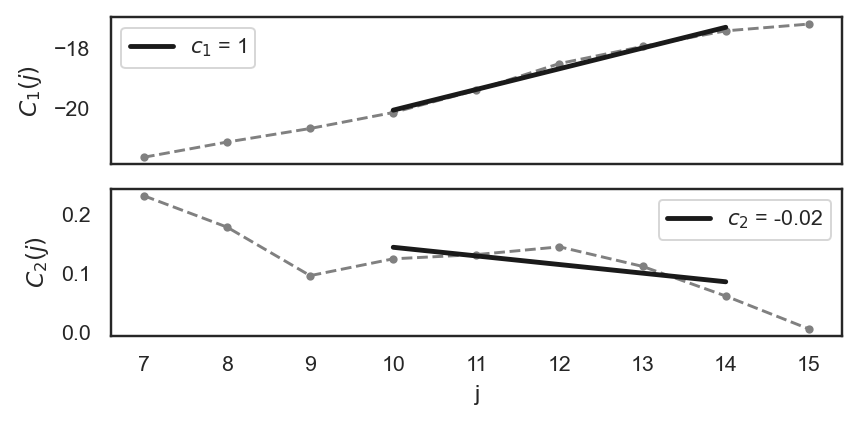

In [17]:
lwt.cumulants.plot(signal_idx=40, figsize=(5, 2.5), j1=7)

We can easily access the log-cumulants using the `lwt.cumulants.c{m}` syntax

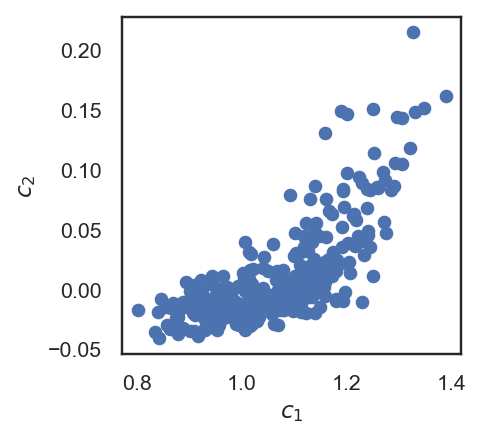

In [18]:
plt.figure(figsize=(2.5, 2.5))

plt.scatter(lwt.cumulants.c1, lwt.cumulants.c2)

plt.gca().set(xlabel='$c_1$', ylabel='$c_2$')
plt.show()

### Alpha band dynamics

Let's get the envelope of the alpha band in the recording

In [19]:
from scipy.signal import morlet2, cwt

w0 = 10
freq = 10

s = w0 * sfreq / (2 * freq * np.pi)
envelope = np.abs(cwt(data[:, 0], morlet2, [s], w=w0))[0]

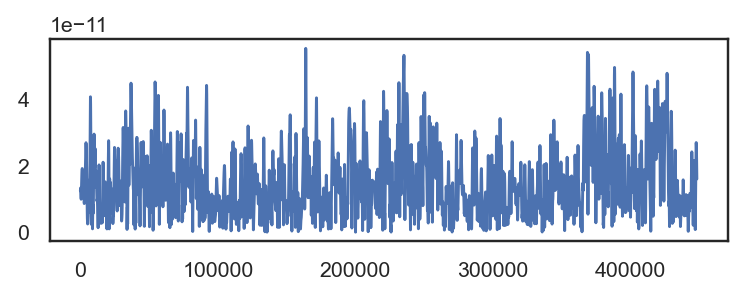

In [20]:
plt.figure(figsize=(5, 1.5))
plt.plot(envelope)
plt.show()

Now we can obtain the multifractal exponents for that envelope series

In [ ]:
WT = wavelet_analysis(envelope, p_exp=2, j1=10, j2_reg=15, gamint=1)
lwt = mf_analysis(WT.wt_leaders, [(10, 15)])

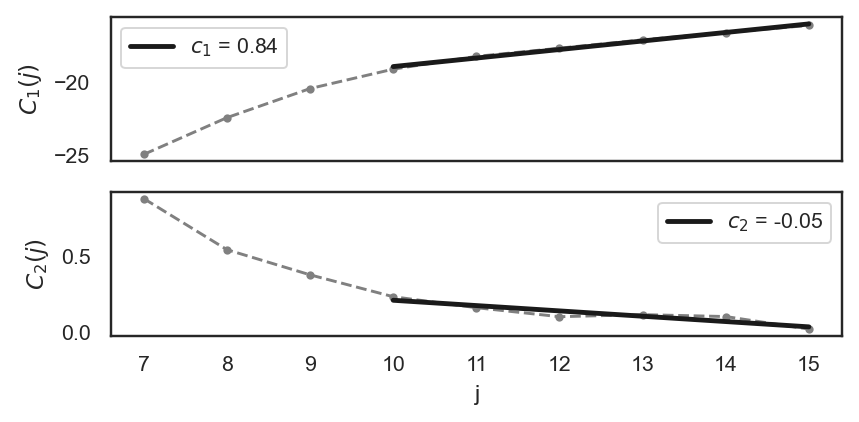

In [21]:
lwt.cumulants.plot(figsize=(5, 2.5), j1=7)

## Bootstrap-derived confidence intervals

We can bootstrap any computed leaders using the `bootstrap` method, specifying the number of repetitions `R`, and the minimal scale at which to perform the bootstrap `min_scale` in order to avoid memory issues

In [30]:
WT.wt_leaders.bootstrap(R=100, min_scale=7)

lwt = mf_analysis(WT.wt_leaders, [(10, 15)])

Plotting functions automatically adjust to the presence of bootstrapped quantities

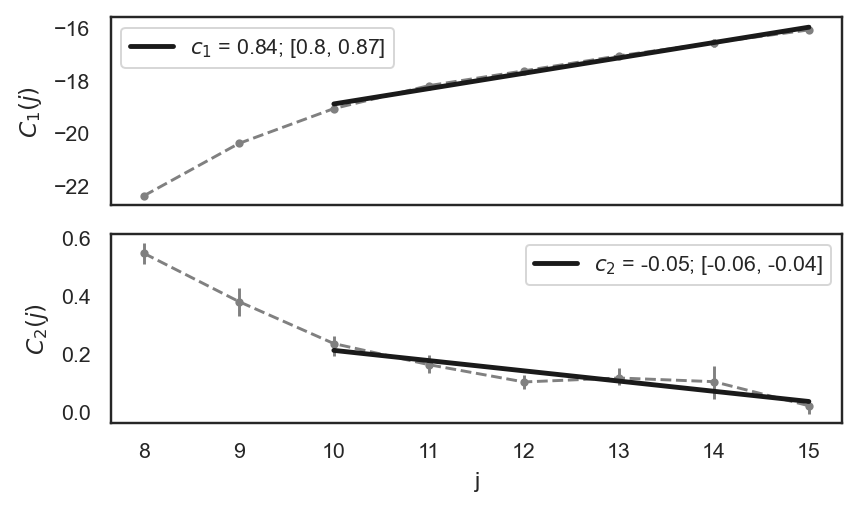

In [32]:
lwt.cumulants.plot(j1=8, figsize=(5, 3))

Boostrap-derived statistics can be obtained by adding a prefix to the `lwt.cumulants.c{m}` syntax.

For instance, the empirical confidence intervals can be obtained with:

In [34]:
lwt.cumulants.CIE_c2

array([[[-0.03966376, -0.06274335]]])

## Documentation

Code is documented, and can be obtained from notebooks by using `?`

In [39]:
from pymultifracs.mfa import mf_analysis